In [1]:
import sys
# for local development
RT_LIBS_PATH = "/Users/alex/Dev_projects/MyOwnRepo/rt_libs/src"
BA_LIBS_PATH = "/Users/alex/Dev_projects/MyOwnRepo/basic_application/src"
sys.path.append(RT_LIBS_PATH)
sys.path.append(BA_LIBS_PATH)

In [2]:
%matplotlib notebook
db_connect_params = {
    #"host" : "185.117.118.107",
    "host": "217.197.116.177",
    "port" : 59000,
    "user" : "alex",
    "password" : "Xrxcmr758",
    "database" : "rt"
}

In [3]:
import logging

import numpy as np
import pandas as pd
from basic_application import with_exception

logger = logging.getLogger(__name__)


In [206]:
QUERY = """
WITH

    toUInt32(%(period)s) AS p_period,
    toUInt32(%(start)s) AS ts_min_,
    toUInt32(%(end)s) AS ts_max,
    %(pair)s AS p_pair,
    
    toUInt32(ts_min_ - p_period) AS ts_min

SELECT 
	tb_ts.ts as ts,
	FROM_UNIXTIME(toUInt32(tb_ts.ts)) as dt,
	lowest_ask,
	highest_bid,
	asks,
	bids,
	buy_vol,
	sell_vol,
	buy_num,
	sell_num

FROM 
	(SELECT 
		tb_orderbook.ts as ts,
		tb_orderbook.lowest_ask as lowest_ask,
		tb_orderbook.highest_bid as highest_bid,
		tb_orderbook.asks as asks,
		tb_orderbook.bids as bids,
		
		tb_trades.buy_vol as buy_vol,
		tb_trades.sell_vol as sell_vol,
		tb_trades.buy_num as buy_num,
		tb_trades.sell_num as sell_num
		
	FROM     
	    
	
		(SELECT 
			period_gr + ts_min as ts,
			toFloat32(any(lowest_ask)) as lowest_ask,
			toFloat32(any(highest_bid)) as highest_bid,
			any(asks) as asks,
			any(bids) as bids
	
		FROM
	    
			(SELECT
				ts - ts_max AS ts_group,
				CEIL((`ts`-`ts_min`) / p_period) * p_period  AS `period_gr`, 
				lowest_ask,
				highest_bid, 
				asks,
				bids
			FROM orderbook 
			WHERE ts > ts_min and ts <= ts_max and pair=p_pair
			ORDER BY ts_group DESC
			) AS tb_orderbook_ungrouped
		GROUP BY period_gr
		) as tb_orderbook
	
	FULL JOIN
	
	(SELECT
		toUInt32(period + ts_min) AS ts,
		toFloat32(SUM(buy_vol)) as buy_vol,
		toFloat32(SUM(sell_vol)) as sell_vol,
		
		SUM(buy_num) as buy_num,
		SUM(sell_num) as sell_num
	
	FROM
		(SELECT
		    CEIL((`ts`-`ts_min`) / p_period) * p_period  AS `period`,
		    --`type` as `type_gr`,
		    --`rate` as rate_gr,
		    --`amount` as `amount_gr`,
		    --`total` as `total_ts`,
		    
		    if(`type`='buy', total, 0) as `buy_vol`,
		  	if(`type`='buy', 1, 0) as `buy_num`,
		    if(`type`='sell', total, 0) as `sell_vol`,
		    if(`type`='sell', 1, 0) as `sell_num`
	
		FROM trades
		WHERE ts > ts_min AND ts <= ts_max AND pair=p_pair) AS tb_trades_ungrouped
	GROUP BY period
	) AS tb_trades ON tb_trades.ts = tb_orderbook.ts
	
	ORDER BY ts ASC ) AS tb_ob_trades
	
	RIGHT JOIN
	
	(SELECT arrayJoin (range(toUInt32(ts_min+p_period), toUInt32(ts_max+p_period), p_period)) AS ts) as tb_ts on tb_ts.ts = tb_ob_trades.ts
ORDER BY tb_ts.ts ASC"""

In [248]:
import pytz
import datetime
import pandas as pd


class DataProviderError(Exception):
    """Класс ошибки DataProvider. Необходим при обработке ошибок в трейдере """
    pass


class TooManyGapsError(DataProviderError):
    MESSAGE = "{0} gaps in {1} records"
    """Класс ошибки DataProvider. Необходим при обработке ошибок в трейдере """
    def __init__(self, gaps, total):
        self.message = self.MESSAGE.format(gaps, total)
        self.gaps = gaps
        self.total = total
        super().__init__(self.message)


class UpToDateError(DataProviderError):
    """Класс ошибки DataProvider. Необходим при обработке ошибок в трейдере """
    pass



class AbstractDataProvider:
    """Базовый класс, который обхявляет интерфейс DataProvider.
    Не содержит реализаци подключения к данным, но предоставляет базовые методы для пред и пост обработки данных.
    """
    def get(self, start, end, period, pair=None) -> pd.DataFrame:
        """
        Метод возвращает данные по котировкам. В параметрах задается начало и окончание периода.

        :param start: Начало периода. Может быть передано как в строковом формате, так и в UNIX TIMESTAMP.
        :param end: Окончание периода. Может быть передано как в строковом формате, так и в UNIX TIMESTAMP.
        :param period: Шаг выгрузки данных в секундах (60-300-600и т.д.)
        :param pair: Пара для отбора. Если None - будут овзвращены все пары.
        :return: pandas DataFrame с данными о котировках.
        """
        raise NotImplementedError

    def get_by_periods(self, ts, period, num_of_period, pair=None) -> pd.DataFrame:
        """
        Метод возвращает данные по котировкам. В параметрах задается окончание периода и количество периодов 'в глубину'.
        :param ts: Окончание периода (крайняя дата). Может быть передано как в строковом формате, так и в UNIX TIMESTAMP.
        :param period: Шаг выгрузки данных в секундах (60-300-600и т.д.)
        :param num_of_period: количество шагов выгрузки данных.
        :param pair: Пар для отбора. Если None - будут овзвращены все пары.
        :return: pandas DataFrame с данными о котировках.
        """
        ts_end = self.date_to_unix_ts_in_utc(ts)
        start = ts_end - period * num_of_period
        end = ts_end
        result = self.get(start, end, period, pair=pair)
        return result

    @staticmethod
    def date_to_unix_ts_in_utc(date) -> int:
        """Метод преобразует время в строковом формате в UNIXTIMESTAMP.
        """
        if isinstance(date, str):
            timezone = pytz.timezone("UTC")
            without_timezone = datetime.datetime.strptime(date, "%Y-%m-%d %H:%M:%S")
            with_timezone = timezone.localize(without_timezone)
            transformed = int(with_timezone.timestamp())
        else:
            transformed = int(date)
        return transformed



In [264]:
class DbDataProviderV2(AbstractDataProvider):
    
    GAPS_THRESHOLD = 0.3
    
    DICT_COLUMNS = ["asks", "bids"]
    STR_COLUMNS = ["pair"]
    INT_COLUMNS = ["ts", "buy_num", "sell_num"]
    WO_CONVERT = ["dt"]
    INDEX_COL = "ts"

    QUERY = QUERY

    def __init__(self, conn):
        self.conn = conn
        self.raw_data = None
        self.col_names = None

    @with_exception(DataProviderError)
    def get(self, start, end, period, pair=None, raise_errors=False):
        params = self._build_params(start, end, period, pair)
        self.conn.cursor.execute(self.QUERY, parameters=params)
        self.raw_data = self.conn.cursor.fetchall()
        self.col_names = [col[0] for col in self.conn.cursor.columns_with_types]

        data = self._transform(self.raw_data, self.col_names)
        if raise_errors:
            self._check_data(data)
            
        data = self._fill_gaps(data)

        return data

    def get_by_periods(self, ts, period, num_of_period, pair=None, raise_errors=False) -> pd.DataFrame:
        ts_end = self.date_to_unix_ts_in_utc(ts)
        start = ts_end - period * (num_of_period - 1)
        end = ts_end
        result = self.get(start, end, period, pair=pair, raise_errors=raise_errors)
        return result

    def _build_params(self, start, end, period, pair):
        params = dict()
        params["start"] = self.date_to_unix_ts_in_utc(start)
        params["end"] = self.date_to_unix_ts_in_utc(end)
        params["period"] = period
        params["pair"] = pair
        return params

    def _transform(self, raw_data, col_names):
        data = pd.DataFrame(raw_data, columns=col_names)

        for col in data.columns:
            if col in self.STR_COLUMNS:
                data[col] = data[col].astype(str)
            elif col in self.INT_COLUMNS:
                data[col] = data[col].astype(int)
            elif col in self.DICT_COLUMNS:
                pass
            else:
                if col not in self.WO_CONVERT:
                    data[col] = data[col].astype(np.float32)

        if self.INDEX_COL in data.columns:
            data = data.set_index(self.INDEX_COL)

        return data
    

    def _check_data(self, data):
        zero_counts = sum(data["highest_bid"]==0)
        data_lenght = len(data["highest_bid"])

        if zero_counts/data_lenght > self.GAPS_THRESHOLD:
            raise TooManyGapsError(zero_counts, data_lenght)

        highest_bid = data.loc[max(data.index), "highest_bid"]
        if not highest_bid:
            raise UpToDateError()
            
    def _fill_gaps(self, data):
        data['lowest_ask'] = data['lowest_ask'].replace(to_replace=0, method='bfill')
        data['highest_bid'] = data['highest_bid'].replace(to_replace=0, method='bfill')
        data['asks'] = data['asks'].replace(to_replace=dict(), method='bfill')
        data['bids'] = data['bids'].replace(to_replace=dict(), method='bfill')
        
        return data
        

# DB v2 - книга заказов

## Загрузка данных

In [4]:
from data_providers import ClickHouseConnector
from data_providers import DbDataProviderV2
from train_tools import plot_and_go

import numpy as np

Cursor created, database connection established
Cursor closed


<IPython.core.display.Javascript object>


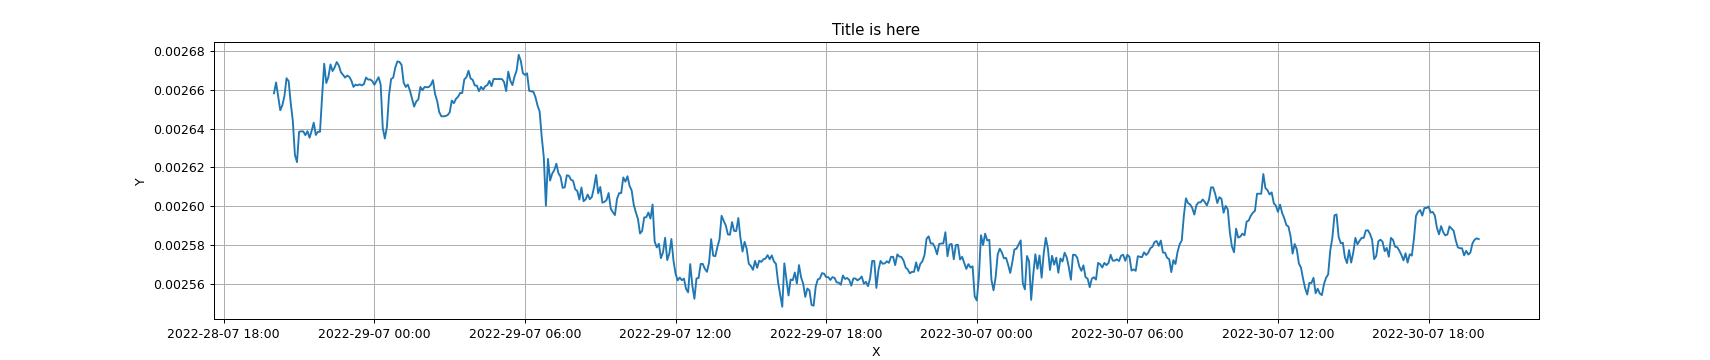

(577, 9)


In [16]:
pair = "BTC_LTC",
start = "2022-07-28 20:00:00"
end = "2022-07-30 20:00:00"
period = 300 

with ClickHouseConnector(db_connect_params) as connector:
    
    data_provider = DbDataProviderV2(connector)
    data = data_provider.get(start, end, period, pair=pair)
    
plot_and_go(data, fig_x=19, fig_y=4, dpi=50)




In [267]:
data.head(100)

,dt,lowest_ask,highest_bid,asks,bids,buy_vol,sell_vol,buy_num,sell_num
ts,,,,,,,,,
1659042000,2022-07-28 21:00:00,24023.191406,24015.669922,"{'24023.19071400': 0.0013597599463537335, '240...","{'24015.66960825': 0.00027240999042987823, '23...",896.953369,7045.496094,22,28
1659042300,2022-07-28 21:05:00,24137.792969,24135.939453,"{'24137.79329990': 0.49838992953300476, '24186...","{'24135.93918898': 0.0015714799519628286, '240...",1346.669800,7661.531738,26,15
1659042600,2022-07-28 21:10:00,24101.425781,24101.425781,"{'24101.42565935': 0.2199999988079071, '24149....","{'24101.42565934': 0.30799999833106995, '24053...",2833.399902,3175.599609,24,25
1659042900,2022-07-28 21:15:00,24079.500000,24077.986328,"{'24079.49990257': 0.0015365900471806526, '241...","{'24077.98552642': 0.06576704233884811, '24029...",19130.958984,1194.874634,27,27


Cursor created, database connection established
Cursor closed


<IPython.core.display.Javascript object>


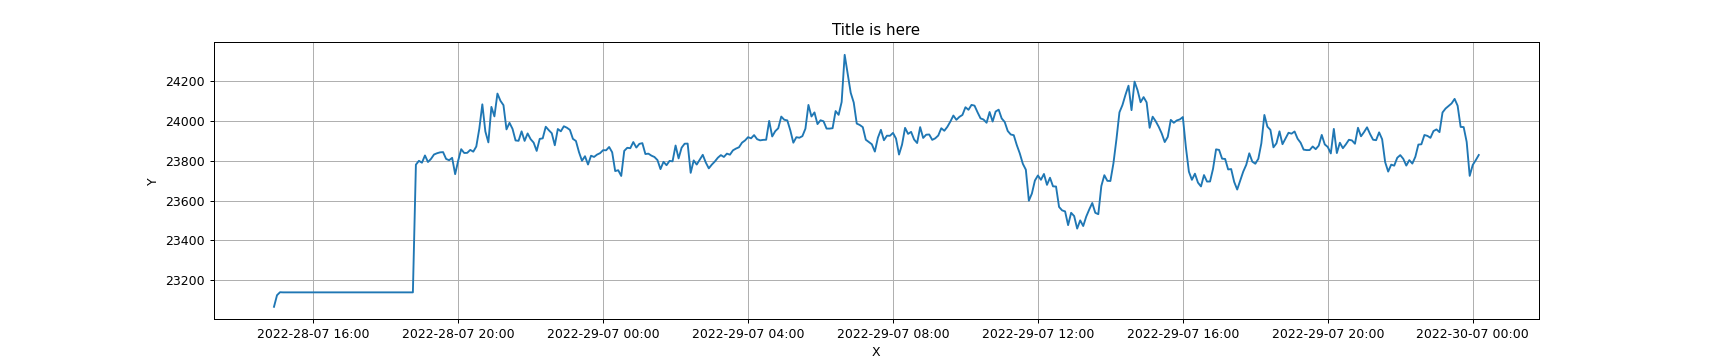

(400, 9)


In [10]:
pair = "USDT_BTC",
end = "2022-07-30 00:10:00"
period = 300 
num_of_period = 400

with ClickHouseConnector(db_connect_params) as connector:
    
    data_provider = DbDataProviderV2(connector)
    data = data_provider.get_by_periods(end, period, num_of_period, pair=pair, raise_errors=False)
    
plot_and_go(data, fig_x=19, fig_y=4, dpi=50)


In [11]:
data.head(100)

,dt,lowest_ask,highest_bid,asks,bids,buy_vol,sell_vol,buy_num,sell_num
ts,,,,,,,,,
1659020100,2022-07-28 14:55:00,23066.992188,23066.916016,"{'23066.99039944': 0.15000000596046448, '23113...","{'23066.91670715': 0.0012013600207865238, '230...",6117.520020,512.563354,28,15
1659020400,2022-07-28 15:00:00,23125.138672,23122.826172,"{'23125.13911782': 0.08799999952316284, '23171...","{'23122.82699851': 0.08799999952316284, '23076...",30029.779297,19793.601562,42,22
1659020700,2022-07-28 15:05:00,23140.201172,23139.837891,"{'23140.20136086': 0.08799999952316284, '23186...","{'23139.83772303': 0.2199999988079071, '23093....",6296.027832,27850.261719,24,29
1659021000,2022-07-28 15:10:00,23139.482422,23139.482422,{},{},0.000000,0.000000,0,0
1659021300,2022-07-28 15:15:00,23139.482422,23139.482422,{},{},0.000000,0.000000,0,0
...,...,...,...,...,...,...,...,...,...
1659048600,2022-07-28 22:50:00,23948.277344,23945.076172,"{'23948.27660384': 0.20999999344348907, '23996...","{'23945.07619465': 0.000779589987359941, '2389...",10474.535156,2559.486572,37,29
1659048900,2022-07-28 22:55:00,23973.585938,23970.980469,"{'23973.58634300': 0.2939999997615814, '24021....","{'23970.97916379': 0.20999999344348907, '23923...",1765.624512,2163.204834,24,36
1659049200,2022-07-28 23:00:00,23966.320312,23966.320312,"{'23966.32016378': 0.20999999344348907, '24014...","{'23966.32016377': 0.2939999997615814, '23918....",274.845673,1398.606079,10,19


In [233]:
# 1. Посчитать количество пропусков - если оно превышает порог - выдать ошибку на неполнвые данные
# 2. Проверить последнюю запись, если она 0 - выдать ошибку на неполные данные
# 3. Заполнить пробелы в данных через bfill


threshold = 0.3
zero_counts = sum(data["highest_bid"]==0)/len(data["highest_bid"])


if zero_counts > threshold:
    raise Exception("Too many gaps")
    
highest_bid = data.loc[max(data.index), "highest_bid"]
if not highest_bid:
    raise Exception("No actual data")




Exception: Too many gaps

In [219]:
d = 0.00000001

In [220]:
if d:
    print(1)

1


In [71]:
data_provider.raw_data

[]

In [14]:
data_provider.date_to_unix_ts_in_utc(params["end"])

1658779200

In [8]:
import pandas as pd

In [9]:
data_provider.raw_data

[]

In [9]:
data = pd.DataFrame(data_provider.raw_data, columns=data_provider.col_names)

In [10]:
data.head()

,ts,lowest_ask,highest_bid,asks,bids,buy_vol,sell_vol,buy_num,sell_num
0,1.658778e+09,21720.677734,21719.128906,"{'21720.67797305': 0.26600000262260437, '21764...","{'21719.12893031': 0.1899999976158142, '21675....",1321.739868,4747.137695,32,40
1,1.658779e+09,21853.955078,21852.861328,"{'21853.95422576': 0.0011225700145587325, '218...","{'21852.86149862': 0.0016734700184315443, '218...",32692.376953,1858.128662,64,47
2,1.658779e+09,21893.822266,21892.546875,"{'21893.82311050': 0.029999999329447746, '2193...","{'21892.54771685': 0.07599999755620956, '21848...",94154.976562,19310.851562,68,49


In [ ]:
data = data.fillna(0)
        data = data.replace(to_replace=0, method='ffill')

In [12]:
data.head()

,lowest_ask,highest_bid,asks,bids,buy_vol,sell_vol,buy_num,sell_num
ts,,,,,,,,
1658778900,21853.955078,21852.861328,"{'21853.95422576': 0.0011225700145587325, '218...","{'21852.86149862': 0.0016734700184315443, '218...",32692.376953,1994.559204,64,53
1658779200,21893.822266,21892.546875,"{'21893.82311050': 0.029999999329447746, '2193...","{'21892.54771685': 0.07599999755620956, '21848...",94154.976562,19174.419922,68,43


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10 entries, 1658776500 to 1658779200
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   lowest_ask   10 non-null     float32
 1   highest_bid  10 non-null     float32
 2   asks         10 non-null     object 
 3   bids         10 non-null     object 
 4   buy_vol      10 non-null     float32
 5   sell_vol     10 non-null     float32
 6   buy_num      10 non-null     int64  
 7   sell_num     10 non-null     int64  
dtypes: float32(4), int64(2), object(2)
memory usage: 560.0+ bytes


## Преобразование orderbook

In [10]:
# функция расчета highest_bid,lowest_ask
def get_rates(asks, bids):
    lowest_ask = np.min(np.array(list(map(float, asks.keys()))))
    highest_bid = np.max(np.array(list(map(float, bids.keys()))))
    return lowest_ask, highest_bid
# ----------------------------------------

# функция расчета маски
LEVELS = [0.005, 0.01, 0.02, 0.03, 0.05]
def get_volumes(asks, bids, lowest_ask, highest_bid):
    keys_asks = np.array(list(map(float, asks.keys())))
    vols_asks = np.array(list(map(float, asks.values())))
    keys_bids = np.array(list(map(float, bids.keys())))
    vols_bids = np.array(list(map(float, bids.values())))
    
    asks_sum, bids_sum = [], []
    for coef in LEVELS:
        mask_ask = keys_asks < lowest_ask * (1 + coef)
        asks_sum.append(sum(vols_asks[mask_ask]))

        mask_bid = keys_bids > highest_bid * (1 - coef)
        bids_sum.append(sum(vols_bids[mask_bid]))
    
    return np.array(asks_sum), np.array(bids_sum)

In [13]:
asks = []
bids = []
for i in range(1, len(data)):
    current_row = data.iloc[i, :]
    previous_row = data.iloc[i-1, :]
    
    lowest_ask, highest_bid = get_rates(current_row.loc["asks"], current_row.loc["bids"])
    
    asks_vol, bids_vol = get_volumes(current_row.loc["asks"], current_row.loc["bids"], lowest_ask, highest_bid)
    asks_vol_prev, bids_vol_prev = get_volumes(previous_row.loc["asks"], previous_row.loc["bids"], lowest_ask, highest_bid)
    
    
    asks_vol_diff = asks_vol - asks_vol_prev
    bids_vol_diff = bids_vol - bids_vol_prev
    
    asks.append(asks_vol_diff)
    bids.append(bids_vol_diff)
    

In [15]:
bids

[array([-1.2731764 , -2.83346489, -6.32753277, -0.96208433, -0.96208433]),
 array([-5.97411159, -1.83229932, -0.22229921, -0.17605254, -0.17605254]),
 array([0.08392   , 0.39186692, 0.92728108, 0.34080213, 0.34080213]),
 array([-5.07157943, -1.4803451 , -0.99916899, -0.55314554, -0.55314554]),
 array([3.89684129, 2.93201274, 2.46083647, 2.04893978, 2.04893978]),
 array([5.36948082, 1.81630167, 1.44233833, 1.80339021, 1.80339021]),
 array([ 0.69822763, -0.44858851,  0.16795506, -0.74917109, -0.74917109]),
 array([-0.82001598, -0.99457131, -1.53087646, -0.56470303, -0.56470303]),
 array([4.32501909, 2.17918345, 2.17937547, 1.19459011, 1.19459011]),
 array([-1.41447295, -1.60443175, -1.68575162, -0.74428859, -0.74428859]),
 array([-0.18537758, -0.18702744,  0.21939434, -0.49287847, -0.49287847]),
 array([1.19831136, 0.6267342 , 1.6040683 , 0.53992612, 0.53992612]),
 array([-1.54482916, -1.69537765, -1.70280284, -1.03477351, -1.03477351]),
 array([ 4.14989556,  3.4681052 ,  0.48215181, -0.

## Multiple train dataset downloading

In [6]:
from data_providers import BatchTaskHandler
from data_providers import ClickHouseConnector
from data_providers import DbDataProvider
from train_tools import plot_and_go

In [7]:
import pandas as pd

class BatchTaskHandler:
    def __init__(self, provider):
        self.provider = provider
        self.pages = list()

    def process(self, tasks, scale_factor=0):
        for task in tasks:
            data = self.provider.get(task["start"], task["end"], task["period"], pairs=task["pairs"])
            self.pages.append(data)
        dataset = self.merge(self.pages, scale_factor)
        return dataset

    @staticmethod
    def merge(data, scale_factor):
        dataset = pd.DataFrame()
        for i in range(len(data)):
            if scale_factor:
                scale = scale_factor / data[i].loc[:, "lowest_ask"].values[0]

                data[i].loc[:, "lowest_ask"] = scale * data[i].loc[:, "lowest_ask"]
                data[i].loc[:, "highest_bid"] = scale * data[i].loc[:, "highest_bid"]

                scale_factor = data[i].loc[:, "lowest_ask"].values[-1]

            dataset = dataset.append(data[i], ignore_index=True)
        return dataset


In [8]:
start = "2022-06-10 00:00:00"
end = "2022-06-13 00:00:00"
period = 60

tasks = [
    {"start": start, "end": end, "period": period, "pairs": ["BTC_LTC"]},
    {"start": start, "end": end, "period": period, "pairs": ["USDT_BTC"]},
    #{"pair": "BTC_XMR", "start": start, "end": end, "period": period},
    #{"pair": "USDT_WIN", "start": start, "end": end, "period": period}
]

Cursor created, database connection established
/var/folders/sk/hq18v07n541fcm73_jz_p_k00000gn/T/ipykernel_59743/577402792.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(data[i], ignore_index=True)
/var/folders/sk/hq18v07n541fcm73_jz_p_k00000gn/T/ipykernel_59743/577402792.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(data[i], ignore_index=True)
Cursor closed


<IPython.core.display.Javascript object>


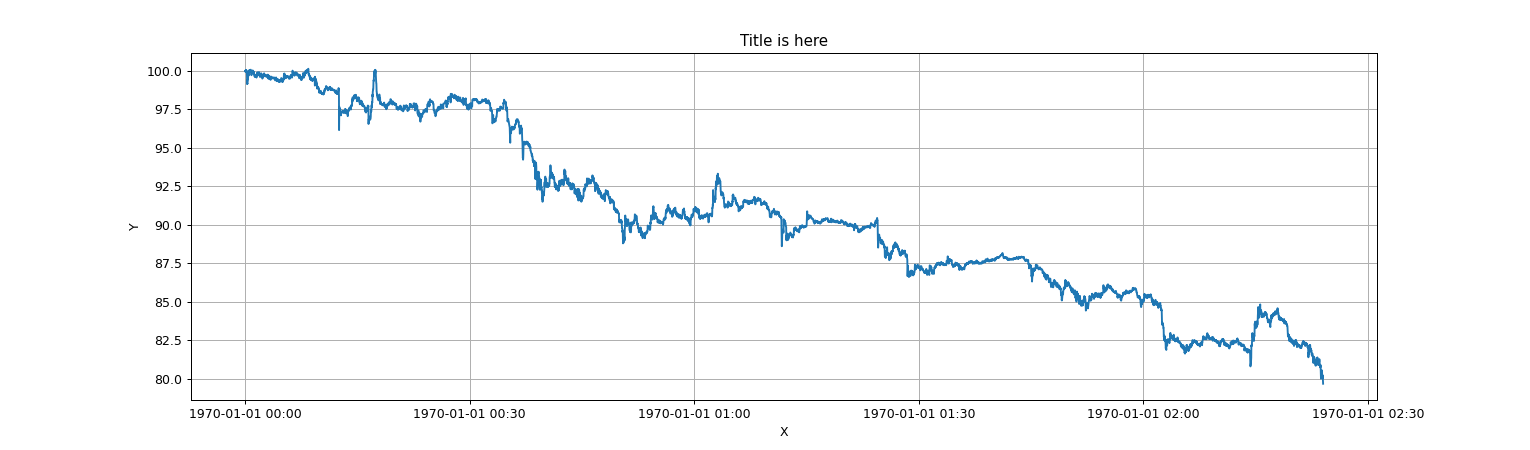

(8642, 3)


In [10]:
with ClickHouseConnector(db_connect_params) as connector:    
    data_provider = DbDataProvider(connector)
    batch_handler = BatchTaskHandler(data_provider)
    dataset = batch_handler.process(tasks, scale_factor=100)
    
plot_and_go(dataset)

## Trade dataset downloading

In [11]:
from data_providers import ClickHouseConnector
from data_providers import DbDataProvider
from train_tools import plot_and_go

import time

Cursor created, database connection established
Cursor closed


<IPython.core.display.Javascript object>


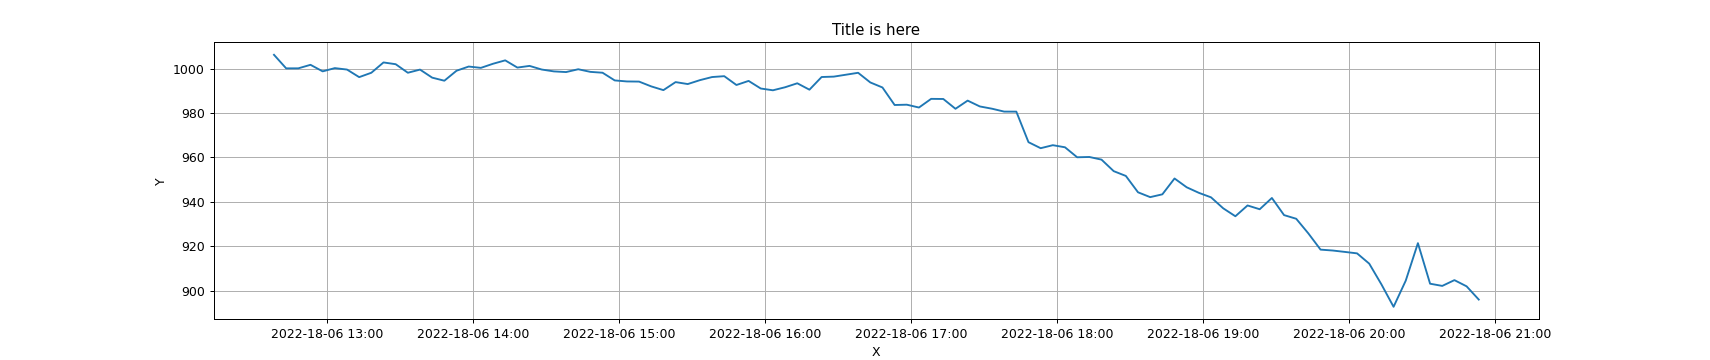

(100, 3)


In [12]:
pair = "USDT_BTC"

ts = int(time.time())
period = 300
num_of_periods = 100
pairs = ["USDT_ETH"]

with ClickHouseConnector(db_connect_params) as connector:
    
    data_provider = DbDataProvider(connector)
    data = data_provider.get_by_periods(ts, period, num_of_periods, pairs=pairs)
    
plot_and_go(data, fig_x=19, fig_y=4, dpi=50)


